In [1]:
%load_ext autoreload
%autoreload 2
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
import numpy as np
import torch
from tqdm import tqdm
from problems import Problem, Rosenbrock, Himmelblau
from datetime import datetime

import os
import sys
sys.path.append("..")
from src.optimizers.hessianfree import HessianFree

In [2]:
# The empirical Fisher diagonal (Section 20.11.3)
def empirical_fisher_diagonal(net, xs, ys, criterion):
    grads = list()
    for (x, y) in zip(xs, ys):
        fi = criterion(net(x), y)
        grads.append(torch.autograd.grad(fi, xs,
                                         retain_graph=False))

    vec = torch.cat([(torch.stack(p) ** 2).mean(0).detach().flatten()
                     for p in zip(*grads)])
    return vec

In [19]:
def run_optimization(problem, x_init, optmizer_class,
                     n_iter=100, **optimizer_kwargs):
    x_t = torch.tensor(x_init, requires_grad=True)
    optimizer = optmizer_class([x_t], **optimizer_kwargs)
    y_target = torch.tensor(0.0)
    path = np.empty((n_iter + 1, 2))
    path[0, :] = x_init

    for i in tqdm(range(1, n_iter + 1)):
        if optimizer.__class__.__name__ == "HessianFree":
            def closure():
                _y_pred = problem(x=x_t)
                mse_loss = torch.nn.MSELoss()
                _loss = mse_loss(_y_pred, y_target)
                _loss.backward(create_graph=True)
                return _loss, _y_pred
            optimizer.zero_grad()
            def M_inv():
                return empirical_fisher_diagonal(problem, list([x_t]), [y_target], torch.nn.L1Loss())
            optimizer.step(closure=closure, M_inv=None)
        else:
            optimizer.zero_grad()
            y_pred = problem(x=x_t)
            mse_loss = torch.nn.L1Loss()
            loss = mse_loss(y_pred, y_target)
            loss.backward(create_graph=True)
            optimizer.step()
        path[i, :] = x_t.clone().detach().numpy()
    # transpose
    return path.T


def _newton(problem: Problem, x_init, n_iter=100, eig_pos=False, **optimizer_kwargs):
    x_t = torch.tensor(x_init, requires_grad=True)
    p = torch.tensor([0.0, 0.0])
    path = np.empty((n_iter + 1, 2))

    loss_fn = torch.nn.L1Loss()
    y_target = torch.tensor(0.0)
    
    for i in tqdm(range(0, n_iter)):
        loss = loss_fn(problem.objective(x=x_t), y_target)
        print(loss)
        if loss > 0.5:
            x_t = x_t.clone().detach() - p
            x_t.requires_grad = True
            path[i, :] = x_t.clone().detach().numpy()
            y_pred = problem.objective(x=x_t)

            def obj(x):
                _y_pred = problem.objective(x)
                loss = loss_fn(_y_pred, y_target)
                return loss
            
            g = torch.autograd.grad(y_pred, x_t, create_graph=True)[0].detach().numpy()
            H = torch.autograd.functional.hessian(obj, x_t).numpy()
            if eig_pos:
                # find eigenvalue of H
                eigvals, eigvecs = np.linalg.eig(H)
                # make H positive definite
                H_pos = np.matmul(eigvecs, np.matmul(np.diag(np.abs(eigvals)), np.linalg.inv(eigvecs)))
                # invert H with numpy
                H_inv = np.linalg.inv(H_pos)
            else:
                H_inv = np.linalg.inv(H)
            p = np.matmul(H_inv, g)
            p = torch.tensor(p)
        else:
            return path.T
    return path.T


def run_optimization_newton(problem, x_init, n_iter=100, **optimizer_kwargs):
    return _newton(problem, x_init, n_iter, eig_pos=False, **optimizer_kwargs)


def run_optimization_newton_pos_eig(problem, x_init, n_iter=100, **optimizer_kwargs):
    return _newton(problem, x_init, n_iter, eig_pos=True, **optimizer_kwargs)


def plot_paths(problem: Problem, paths, colors, names, method, figsize=(
        12, 12), x_lim=(-2, 2), y_lim=(-1, 3), n_seconds=5):
    # transpose
    path_length = max(len(path[0]) for path in paths)
    n_points = 300
    x = np.linspace(*x_lim, n_points)
    y = np.linspace(*y_lim, n_points)
    X, Y = np.meshgrid(x, y)
    Z = problem.objective([X, Y])

    fig, ax = plt.subplots(figsize=figsize)
    ax.contour(X, Y, Z, levels=100, cmap="viridis")

    scatters = [ax.plot([], [], label=label, c=c, marker='o', linestyle='dashed')[0]
                for c, label in zip(colors, names)]
    # ax.legend(prop={'size': 25})

    for minimum in problem.solutions():
        ax.plot(*minimum, "rD")

    def animate(i):
        for path, scatter in zip(paths, scatters):
            if i == 0:
                scatter.set_data([], [])
            else:
                scatter.set_data(path[:, :i])

        ax.set_title(f"Optimizer: {method}; Problem: {problem.__class__.__name__}; Iterations: {str(i)}.")
    ms_per_frame = 1000 * n_seconds / path_length
    anim = FuncAnimation(
        fig,
        animate,
        frames=path_length,
        interval=ms_per_frame)
    return anim


def cut_sequence(seq, eps=1e-2):
    if seq.ndim > 1:
        # seq is a list of paths for individual coordinates
        cut_ids = [seq[0].shape[0]-1]
        for coord in seq:
            for i in range(len(coord)-1, 0, -1):
                cut_id = coord.shape[0]-1
                if (np.abs((coord[i] - coord[i-1]))) > eps:
                    cut_id = i
                    break
            cut_ids.append(cut_id)
        cut_id = min(cut_ids)
        return np.array([coord[:cut_id+1] for coord in seq])
    else:
        for i in range(len(seq)):
            if np.any(np.abs((seq[i] - seq[i-1]))) < eps:
                return np.array(seq[:i+1])


def test_optimizers(x_init, n_iter: int, method: str, freq: int, problem: Problem, save=False):

    if method == 'sgd':
        def optimize(x):
            return run_optimization(
                problem.objective,
                x,
                torch.optim.SGD,
                n_iter=n_iter,
                lr=0.001)
    elif method == 'hf':
        def optimize(x):
            return run_optimization(
                problem.objective,
                x,
                HessianFree,
                n_iter=n_iter,
                lr=1,
                damping=0.5,
                delta_decay=0.95,
                cg_max_iter=500,
                use_gnm=True,
                verbose=False)
    elif method == 'newton':
        def optimize(x):
            return run_optimization_newton(
                problem,
                x,
                n_iter=n_iter)
    elif method == 'pos_newton':
        def optimize(x):
            return run_optimization_newton_pos_eig(
                problem,
                x,
                n_iter=n_iter)
    
    full_paths = []

    for x in x_init:
        path = optimize(x)
        full_paths.append(path)

    if save:
        # reduce number of points in paths
        paths = [cut_sequence(path[:, ::freq]) for path in full_paths]      
        # generate spectrum of colors for each path
        colors = [plt.cm.viridis(i) for i in np.linspace(0, 1, len(paths))]
        # generate list of names from method names and starting points
        names = [f"{method}_{i}" for i,_ in enumerate(x_init)]
        anim = plot_paths(problem, paths, colors, names, method=method, figsize=(12, 7), 
                        x_lim=problem.bounds()[0], y_lim=problem.bounds()[1], n_seconds=7)
        # look for correct counter
        gif_name = f"{problem.__class__.__name__}_{method}.gif"
        counter = 1
        base_name, extension = os.path.splitext(gif_name)
        new_filename = gif_name
        while os.path.exists(new_filename):
            new_filename = f"{base_name}_{counter}{extension}"
            counter += 1
        # save gif
        anim.save(new_filename)
    
    return full_paths

In [21]:
problems = [Rosenbrock(), Himmelblau()]
methods = ['sgd', 'hf', 'newton', 'pos_newton']
# generate 6 random starting points inside the domain x=[-2:2] y=[-2:2]
np.random.seed(45)
x_init = np.random.uniform(-2, 2, size=(8, 2))
x_init = x_init.astype(np.float32)



100%|██████████| 100/100 [00:00<00:00, 1317.84it/s]
MovieWriter ffmpeg unavailable; using Pillow instead.


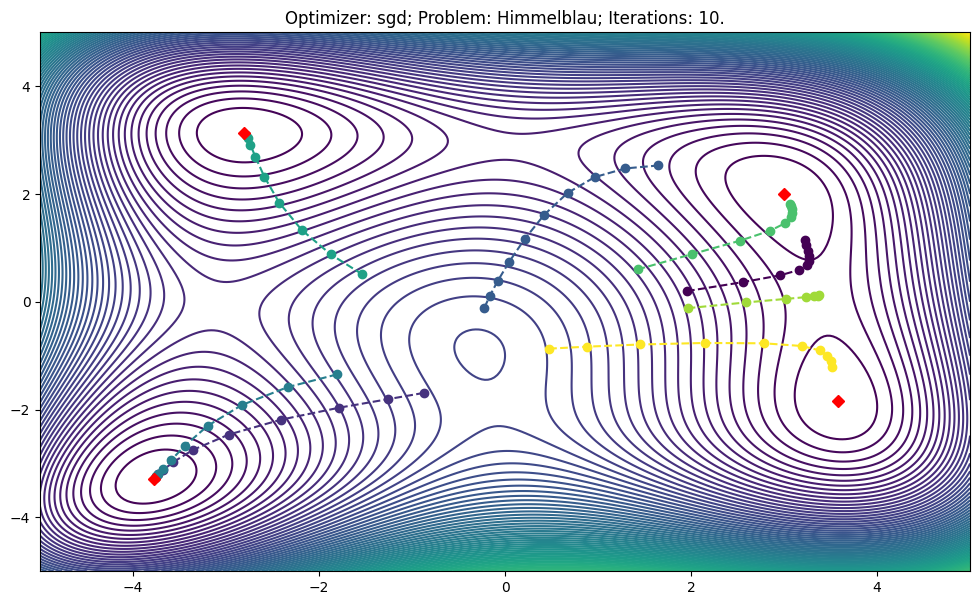

In [126]:
# sgd
_ = test_optimizers(x_init=x_init, n_iter=100, method=methods[0], freq=10, problem=problems[1], save=True)


100%|██████████| 100/100 [00:00<00:00, 138.50it/s]
MovieWriter ffmpeg unavailable; using Pillow instead.


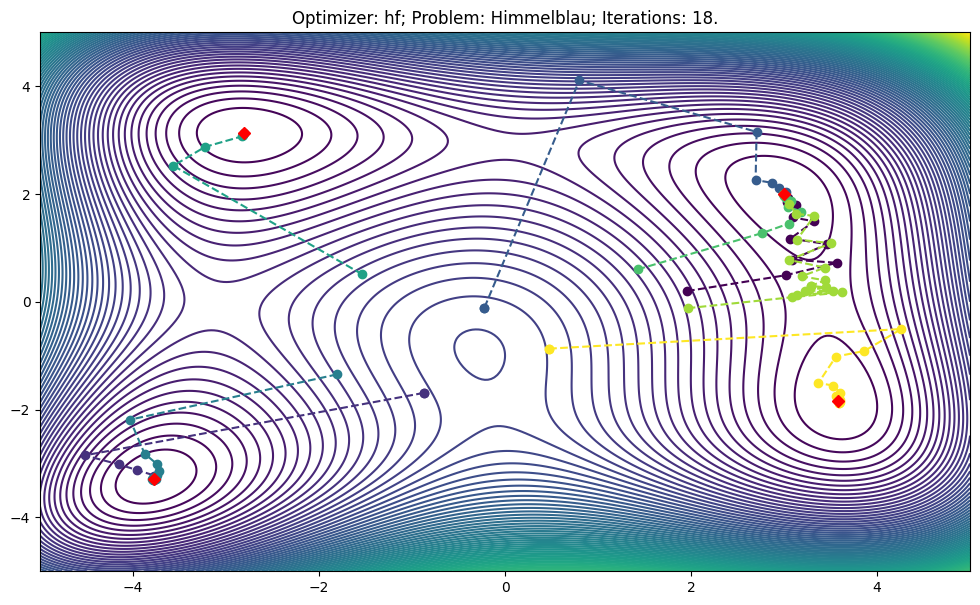

In [130]:
# hf
_ = test_optimizers(x_init=x_init, n_iter=100, method=methods[1], freq=1, problem=problems[1], save=True)


100%|██████████| 100/100 [00:00<00:00, 275.55it/s]
MovieWriter ffmpeg unavailable; using Pillow instead.


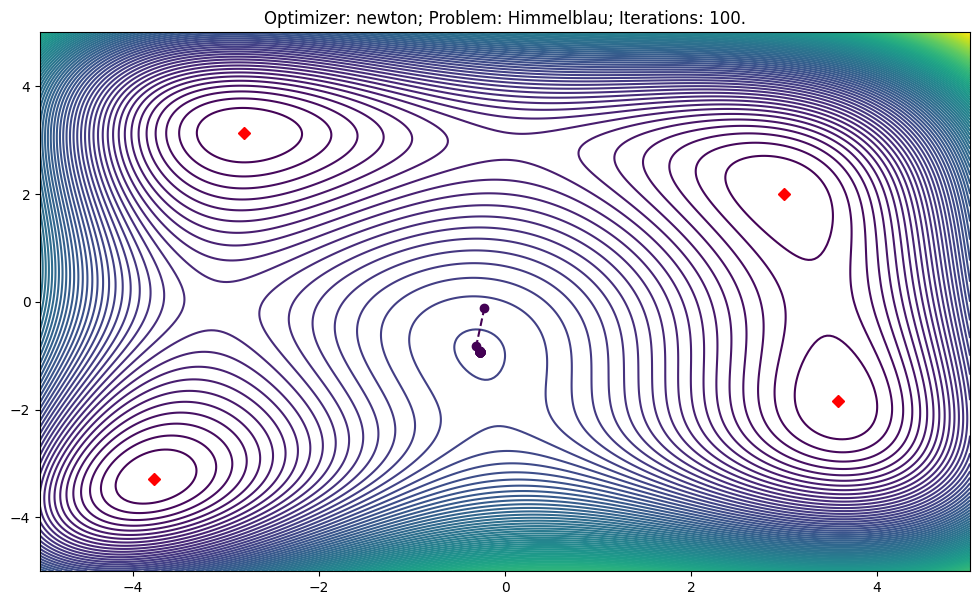

In [10]:
# newton
_ = test_optimizers(x_init=x_init, n_iter=100, method=methods[2], freq=1, problem=problems[1], save=True)


In [31]:
# pos_newton
_ = test_optimizers(x_init=x_init, n_iter=100, method=methods[3], freq=1, problem=problems[1], save=True)

  5%|▌         | 5/100 [00:00<00:00, 244.69it/s]


tensor(167.3966, grad_fn=<MeanBackward0>)
tensor(167.3966, grad_fn=<MeanBackward0>)
tensor(129.2801, grad_fn=<MeanBackward0>)
tensor(14.7474, grad_fn=<MeanBackward0>)
tensor(4.6222, grad_fn=<MeanBackward0>)
tensor(0.0632, grad_fn=<MeanBackward0>)


MovieWriter ffmpeg unavailable; using Pillow instead.
